In [33]:
import numpy as np
import pandas as pd 
import cv2
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.optimizers import Adam,Adadelta
from keras.layers.core import Dropout
from keras.layers.pooling import AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from keras import Input
from keras.callbacks import ModelCheckpoint
%matplotlib inline

In [5]:
training = []
val = []
train_labels = []
val_labels = []

trainCovid = './CovidDataset/Train/Covid/'
trainNorm = './CovidDataset/Train/Normal/'
valCovid = './CovidDataset/Val/Covid/'
valNorm = './CovidDataset/Val/Normal/'

In [14]:
def loadSet(dirPath):
    files = os.listdir(dirPath)
    x =[]
    y = []
    for file in files:
        path = dirPath+file
        img = cv2.resize(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB),(128,128),interpolation = cv2.INTER_AREA)
        x.append(img)
        if(dirPath.split('/')[-2] == 'Covid'):
            y.append(1)
        else:
            y.append(0)
    return x,y        

In [36]:
training,train_labels = loadSet(trainCovid)
tempX, tempY = loadSet(trainNorm)
training.extend(tempX)
train_labels.extend(tempY)

val,val_labels = loadSet(valCovid)
tempX, tempY = loadSet(valNorm)
val.extend(tempX)
val_labels.extend(tempY)

In [37]:
print(np.shape(training))
print(np.shape(train_labels))
print(np.shape(val))
print(np.shape(val_labels))

(224, 128, 128, 3)
(224,)
(60, 128, 128, 3)
(60,)


In [38]:
import random 

temp = list(zip(training, train_labels)) 
random.shuffle(temp) 
training, train_labels = zip(*temp) 

temp = list(zip(val, val_labels)) 
random.shuffle(temp) 
val, val_labels = zip(*temp) 

train_labels = to_categorical(train_labels,num_classes=2)
val_labels = to_categorical(val_labels,num_classes=2)

In [40]:
# VGG model with Imagenet weights
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))

#Adding custom layers to VGG16 

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Use the existing Imagenet weights for VGG16 --> To reduce training time
for layer in baseModel.layers:
    layer.trainable = False

# Finally add custom model to final layer of VGG16    
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [42]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [43]:
model.fit(np.array(training),np.array(train_labels),
          batch_size=20,
          verbose=1,
          epochs=20,
          validation_data=(np.array(val), np.array(val_labels)))

Train on 224 samples, validate on 60 samples
Epoch 1/20
224/224 [==============================] - 24s 109ms/step - loss: 2.6842 - accuracy: 0.7545 - val_loss: 0.0822 - val_accuracy: 0.9833
Epoch 2/20
224/224 [==============================] - 25s 112ms/step - loss: 0.4071 - accuracy: 0.9554 - val_loss: 0.0335 - val_accuracy: 0.9833
Epoch 3/20
224/224 [==============================] - 29s 130ms/step - loss: 0.1633 - accuracy: 0.9777 - val_loss: 0.0861 - val_accuracy: 0.9667
Epoch 4/20
224/224 [==============================] - 27s 123ms/step - loss: 0.3915 - accuracy: 0.9420 - val_loss: 0.0266 - val_accuracy: 0.9833
Epoch 5/20
224/224 [==============================] - 29s 130ms/step - loss: 0.3224 - accuracy: 0.9598 - val_loss: 0.0312 - val_accuracy: 0.9667
Epoch 6/20
224/224 [==============================] - 35s 155ms/step - loss: 0.2485 - accuracy: 0.9688 - val_loss: 0.1532 - val_accuracy: 0.9667
Epoch 7/20
224/224 [==============================] - 28s 126ms/step - loss: 0.0062 -

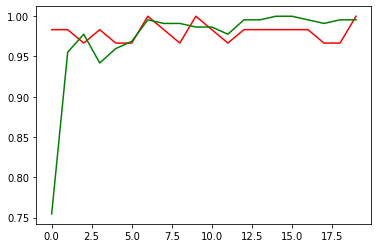

In [44]:
plt.plot(model.history.history['val_accuracy'],'red')
plt.plot(model.history.history['accuracy'],'green')